# Clumpy ensemble

The method utilised in `kosmatau3d` to simulate a clumpy ISM with velocity dispersion $\sigma_{ens}$ in a voxel is to use a fractal ensemble, that is, to use many smaller self-similar clumps with intrinsic velocity dispersion $\sigma_{cl}$. Each clump thus also contributes to the emissivity and opacity at each observing velocity. The discretisation is shown below.

$$
\Delta N_{j,i} \equiv \frac{N_j}{\sqrt{2 \pi \sigma_{ens}^2}} \mathrm{exp} \left( -\frac{(v_{vox} - v_i)^2}{2\sigma_{ens}^2} \right) \delta v_j,
$$

where $j$ refers to a particular clump mass, $i$ refers to the velocity of the clump, and $vox$ refers to the average value for the voxel (so a voxel with $v_{vox} = 0$ would have a Gaussian velocity distribution centered at 0).

Each clump has an emissivity and opacity that follow Gaussian distributions with velocity dispersion $\sigma_{cl}$. Thus the clumps at one systematic velocity will contribute distributions to the emissivity and opacity depending on the observing velocity:

$$
\epsilon_{ens, i} (v_{obs}), \kappa_{ens, i} (v_{obs}) \propto \mathrm{exp} \left( - \frac{(v_{i} - v_{obs})^2}{2 \sigma_{cl}^2} \right).
$$

This results in the final emissivity and opacity of the ensemble depending on two Gaussian distributions,

$$
\begin{align}
\big\{ \epsilon_{ens} (v_{obs}), \kappa_{ens} (v_{obs}) \big\} =& \sum_i exp \left( -\frac{(v_{obs}-v_i)^2}{2 \sigma_{cl}^2} \right) \sum_j \Delta N_{j,i} \big\{ \epsilon_{j}, \kappa_{j} \big\}, \\
\big\{ \epsilon_{ens} (v_{obs}), \kappa_{ens} (v_{obs}) \big\} =& \frac{1}{\sqrt{2 \pi \sigma_{ens}^2}} \sum_i exp \left( -\frac{(v_{obs}-v_i)^2}{2 \sigma_{cl}^2} \right) \sum_j N_{j} \big\{ \epsilon_{j}, \kappa_{j} \big\} exp \left( -\frac{(v_{vox}-v_i)^2}{2 \sigma_{ens}^2} \right),
\end{align}
$$

Due to the two distributions that contribute to the ensemble emissivity and opacity, the final distributions will have a larger effective velocity dispersion:

$$
\sigma_{ens, eff} \equiv \sqrt{\sigma_{ens}^2 + \sigma_{cl}^2}.
$$

In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from copy import copy
from scipy import stats  # noqa
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from IPython.display import Markdown as md

%matplotlib inline

## Example parameters

In [30]:
5.926565041559762*3.533229489438687e-29/(4/3*0.04588465)#/(1-np.exp(-3.533229489438687e-29))

3.4226992647729746e-27

In [15]:
# Ensemble properties
#  ens_test is a flag that can be set to test ensembles of two clump sizes
ens_test = False

if ens_test:
    n_j = [10, 50]  # Using [5, 100] gives a very strange result
    eps_j = [10, 1]
    kap_j = [1.5, 0.5]
    r_j = [0.5, 0.1]
else:
    n_j = [1]
    eps_j = [5.926565041559762]
    kap_j = [3.533229489438687e-29]
    r_j = [0.04588465]

sigma_cl = 0.71
sigma_ens = 1
sigma_ens_tot = np.linalg.norm((sigma_cl, sigma_ens))
n_gauss = 6
n_v = 3
v_vox = 0
ds = 1
nmax = 0

# Debugging flags
old_computation = False
incorrect_computation = False
test_opacity = False
approx = False
plot_all = True

# Most recent solution (independant of the internal velocity grid)
suggested_fix = True

# Plot settings
mpl.rcParams['text.usetex'] = True
figsize = (7, 7)
fontsize = 24
legend_factor = 3/6

# Plotting kwargs
approximated_kwargs = {'label': r'approximated with $N_j$',
                       'ls': '-',
                       'lw': 4,
                       'c': 'xkcd:black',
                       }
calculated_kwargs = {
                     'label': r'calculated using $N_{j, i}$',
                     'ls': '-',
                     'lw': 3,
                     'c': 'xkcd:gold',
                     }
fitted_kwargs = {
                 'label': r'fitted using $N_{j, i}$',
                 'ls': '--',
                 'lw': 2,
                 'c': 'xkcd:sapphire',
                 }

In [16]:
md(r'Below we will examine how this discretisation functions for and ensemble with $\sigma_{ens} =$'
   + '{}'.format(sigma_ens) + r'$\frac{km}{s}$ and ' + '{}'.format(n_j) + r' clumps, each with $\sigma_{cl} =$'
   + '{}'.format(sigma_cl) + r'$\frac{km}{s}$, $\epsilon_\nu =$'
   + '{}'.format(eps_j) + r'$\frac{K}{pc}$, $\kappa_\nu =$'
   + '{}'.format(kap_j) + r'$\frac{1}{pc}$, and a line-of-sight depth of $\Delta s =$'
   + '{}'.format(ds) + r'$pc$. The effective velocity dispersion of the ensemble is thus $\sigma_{ens, eff} =$'
   + '{:.2f}'.format(sigma_ens_tot) + r'$\frac{km}{s}$. This should be enough to cause absorption features.')

Below we will examine how this discretisation functions for and ensemble with $\sigma_{ens} =$1$\frac{km}{s}$ and [1] clumps, each with $\sigma_{cl} =$0.71$\frac{km}{s}$, $\epsilon_\nu =$[5.926565041559762]$\frac{K}{pc}$, $\kappa_\nu =$[3.533229489438687e-29]$\frac{1}{pc}$, and a line-of-sight depth of $\Delta s =$1$pc$. The effective velocity dispersion of the ensemble is thus $\sigma_{ens, eff} =$1.23$\frac{km}{s}$. This should be enough to cause absorption features.

## Functions

### Clump number $\Delta N_{j, i} \delta v$ function

This is a function to compute the discretisation of the clumps with respect to the internal velocity dispersion. Note that *discrete* values should be of type integer, whereas the output of this function is of type float.

 - `n_j`: argument for the total number of clumps in the ensemble. This can be a single number for an ensemble of one clumps size or it can be a list for an ensemble of multiple clump types. In the latter case it is assumed that the largest clump is first.
 - `sigma_ens`: argument for the internal velocity dispersion of the clumps. Note that this must be of type float or int, and must not include the contribution of the intrinsic clump velocity dispersion.
 - `sigma_cl`: kwarg for the intrinsic clump velocity dispersion. It must be of type float or int. The default value is 0.71.
 - `v_i`: kwarg for the internal velocity array. Must be of type ndarray, otherwise the array is created (errors still exist in this). The default value is None.
 - `n_v`: kwarg to adjust the step size in the internal velocity grid, which is the minimum of $\left( \frac{\sigma_{ens}}{n_v}, \frac{\sigma_{cl}}{n_v} \right)$. The default is 1.
 - `v_vox`: kwarg to set the average velocity of the ensemble. The default is 0 km/s.
 - `n_gauss`: kwarg to adjust how many standard deviations are calculated in the discretisation. The default is 4, making the approximation >99% accurate.
 - `suggested_fix`: flag to set whether the original calculation of $\Delta N_j$ is returned or the suggested improvement of $\frac{dN_j}{dv}$.

In [17]:
def delta_n_ji_dv(n_j, sigma_ens, sigma_cl=0.71, v_i=None, n_v=None, v_vox=0, n_gauss=4, suggested_fix=False):

    if not n_v:
        n_v = 1
        
    if isinstance(v_i, np.ndarray):
        dv = v_i[1]-v_i[0]
    else:
        dv = np.minimum(sigma_ens/n_v, sigma_cl/n_v)
        v_i = np.linspace(np.floor(-n_gauss*sigma_ens), np.ceil(n_gauss*sigma_ens), num=int(np.round(2*n_gauss*sigma_ens/dv))+1)
    
    if isinstance(n_j, int) or isinstance(n_j, float):
        n_j = np.asarray([[n_j]])
    elif isinstance(n_j, list):
        n_j = np.asarray(n_j)
    if n_j.ndim == 1:
        n_j = np.asarray([n_j]).reshape(-1, 1)
        
    if suggested_fix:
        suggested_factor = np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_i)**2/2/sigma_ens_tot**2)
    else:
        suggested_factor = 1 / np.sqrt(2*np.pi*sigma_ens**2) * np.exp(-(v_vox-v_i)**2/2/sigma_ens**2) * dv
    
    delta_n_dv = np.asarray([n * suggested_factor for n in n_j])
    # delta_n = delta_n * (n_j / delta_n.sum()) / dv
    
    return delta_n_dv, v_i

### Probability $p_{j, i}$ function

Function to convert the clump number discretisation to combinations $k_{j,i}$ at each internal velocity, then calculate the probability of observing each combination $p_{j,i} \equiv p(k_{j,i})$.

 - `r_cl`: argument for the radius of each clump in the ensemble. It can be of type int or float for an ensemble of one clump type, or a list for an ensemble of multiple clump types.
 - `ds`: kwarg for the scale of the voxel. The default is 1.
 - `delta_n_ji`: kwarg for the discretised number array. The default is 1.
 - `poisson`: if True, use the Poisson distribution to calculate the probabilities. Otherwise use the binomial distribution. The default is False.
 - `nmax`: kwarg used to normalise the discretised numbers. The default is defined in the beginning of the notebook.
 - `debug`: if True, print debugging comments.

In [18]:
def probability(r_cl, ds=1, delta_n_ji=1, poisson=False, nmax=nmax, debug=False):

    if isinstance(r_cl, int) or isinstance(r_cl, float):
        r_cl = np.asarray([[r_cl]])
    elif isinstance(r_cl, list):
        r_cl = np.asarray(r_cl)
    if r_cl.ndim == 1:
        r_cl = np.asarray([r_cl]).reshape(-1, 1)

    if isinstance(delta_n_ji, int) or isinstance(delta_n_ji, float):
        delta_n_ji = np.asarray([[delta_n_ji]])
    elif isinstance(delta_n_ji, list):
        delta_n_ji = np.asarray(delta_n_ji)
    if delta_n_ji.ndim == 1:
        delta_n_ji = np.asarray([delta_n_ji])

    p_j = np.pi*r_cl**2/ds**2

    if nmax:
        factor = np.asarray([[nmax / delta_n_ji[0, i]
                              for i in range(delta_n_ji.shape[1])]
                             for cl in range(delta_n_ji.shape[0])])
    else:
        factor = np.asarray([[np.maximum(1, np.round(delta_n_ji[0, i])) / delta_n_ji[0, i]
                              for i in range(delta_n_ji.shape[1])]
                             for cl in range(delta_n_ji.shape[0])])

    p_scaled = p_j[0]/factor[0]
    # print(p_scaled)
    thresh = 0.95
    i_change = p_scaled > thresh
    # print(i_change, factor, p_j/factor)
    if i_change.any() or np.isnan(p_scaled).any():
        n_temp = np.ceil(delta_n_ji[:, i_change] * thresh*p_j[0]/factor[0][i_change])
        factor[:, i_change] = n_temp/delta_n_ji[:, i_change]

    if debug:
        print(delta_n_ji*factor)

    k_ji_list = [[np.arange(np.round(delta_n_ji[cl, i]*factor[cl, i]) + 1, dtype=int)
                  for cl in range(delta_n_ji.shape[0])]
                 for i in range(delta_n_ji.shape[1])]

    k_ji = np.asarray([[k.flatten() for k in np.meshgrid(*k_ji_list[i])]
                       for i in range(len(k_ji_list))], dtype=object)
    
    # for _ in range(p_scaled.size):
    #     print('{:.6f} {:.6f} {} {} {}'.format(p_scaled[_], factor[0, _], i_change[_], np.round(delta_n_ji[0, _]*factor[0, _]), k_ji_list[_][0]))

    if poisson:
        p_ji = np.asarray([[stats.poisson.pmf(k_ji[i, cl].astype(int),
                                              delta_n_ji[cl, i]*p_j[cl, 0])
                            for i in range(delta_n_ji.shape[1])]
                           for cl in range(delta_n_ji.shape[0])], dtype=object)
    else:
        p_ji = np.asarray([[stats.binom.pmf(k_ji[i, cl].astype(int),
                                            np.round(delta_n_ji[cl, i]*factor[cl, i]),
                                            p_j[cl, 0]/factor[cl, i])
                            for i in range(delta_n_ji.shape[1])]
                           for cl in range(delta_n_ji.shape[0])], dtype=object)

    return p_ji, np.swapaxes(k_ji, 0, 1)

### Clump number $\Delta N_{j,i}$ plotting function

Function to calculate and plot the clump number discretisation. The total mass is also printed.

 - `v_i`: kwarg for the internal velocity array. Must be of type ndarray, otherwise the array is created (errors still exist in this). The default value is None.
 - `n_v`: kwarg to adjust the step size in the internal velocity grid, which is the minimum of $\left( \frac{\sigma_{ens}}{n_v}, \frac{\sigma_{cl}}{n_v} \right)$. The default is 1.
 - `suggested_fix`: flag to set whether the original calculation of $\Delta N_j$ is returned or the suggested improvement of $\frac{dN_j}{dv}$.

In [19]:
def plot_clump_number(v_i=None, n_v=n_v, suggested_fix=suggested_fix):
    
    ensemble_n_dv, v_i = delta_n_ji_dv(n_j, sigma_ens, v_i=v_i, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v, suggested_fix=suggested_fix)
    dv = v_i[1]-v_i[0]
    print(np.shape(ensemble_n_dv))
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    v = np.linspace(v_vox-10, v_vox+10, num=1000)
    dv_obs = v[1]-v[0]
    ax.set_xlabel(r'$v_i \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    if suggested_fix:
        n_dist = np.sum([n * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v)**2/2/sigma_ens_tot**2) for n in n_j], axis=0)
        print('Total Mass (without discretisation): {:.3f} M_sol'.format((n_dist).sum() * dv_obs / np.sqrt(2*np.pi*sigma_cl**2)))
        print('Total Mass (with discretisation): {:.3f} M_sol'.format(ensemble_n_dv.sum() * dv / np.sqrt(2*np.pi*sigma_cl**2)))
        ax.plot(v, n_dist, label='approximated')
        ax.set_ylabel(r'$N_{j,i}$', fontsize=fontsize)
    else:
        n_dist = np.sum([n / np.sqrt(2*np.pi*sigma_ens**2) * np.exp(-(v_vox-v)**2/2/sigma_ens**2) for n in n_j], axis=0)
        print('Total Mass (without discretisation): {:.3f} M_sol'.format((n_dist).sum()*dv_obs))
        print('Total Mass (with discretisation): {:.3f} M_sol'.format(ensemble_n_dv.sum()))
        ensemble_n_dv /= dv
        ax.plot(v, n_dist, label='approximated')
        ax.set_ylabel(r'$\Delta N_{j,i}$', fontsize=fontsize)
    ax.step(v_i, ensemble_n_dv.sum(0), where='mid', label='calculated')
    ax.legend(fontsize=fontsize*legend_factor)
    
    return

### Emission $\left( \left<\epsilon\right>_i, \ \left<\kappa\right>_i, \ \left<I\right>_i \right)$ plotting function

Function to calculate and plot the emission from a clumpy ensemble independent of the scale. (ie. Not averaged over a voxel.) The contributions from each internal velocity are also shown. The calculations can be performed in their original implementation or using the more-efficient suggested calculation.

The final approximated and calculated integrated intensities are also printed.

 - `v_i`: kwarg for the internal velocity array. Must be of type ndarray, otherwise the array is created (errors still exist in this). The default value is None.
 - `n_v`: kwarg to adjust the step size in the internal velocity grid, which is the minimum of $\left( \frac{\sigma_{ens}}{n_v}, \frac{\sigma_{cl}}{n_v} \right)$. The default is defined in the beginning of the notebook.
 - `suggested_fix`: flag to set whether the original calculation of $\Delta N_j$ is returned or the suggested improvement of $\frac{dN_j}{dv}$. The default is defined in the beginning of the notebook.
 - `kind`: kwarg to set the pass to the interpolation function. This can be *gaussian*, *linear*, *nearest*, *nearest-up*, *zero*, *slinear*, *quadratic*, *cubic*, *previous*, or *next*. 'gaussian' fits a gaussian to the emissivity and optical depth using `scipy.optimize.curve_fit` and the widths are averaged, while the others are passed to `scipy.interpolate.interp1d`. The default is *slinear*.

In [20]:
def plot_clumpy_emission(v_i=None, n_v=n_v, suggested_fix=suggested_fix, kind='slinear'):
    
    
    # Calculate the Ndv distribution
    ensemble_n_dv, v_i = delta_n_ji_dv(n_j, sigma_ens, v_i=v_i, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v, suggested_fix=suggested_fix)
    dv = v_i[1]-v_i[0]
    
    
    # Define/adjust the velocity grids as required for the calculations
    if suggested_fix:
        v_obs = v_vox
        v_obs_range = np.linspace(-10, 10, num=1000)
    else:
        v_obs = np.linspace(-10, 10, num=1000)

        
    # Emissivity
    if suggested_fix:
        eps = np.sum([n_j[j]*eps_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs_range)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        eps_ens = np.zeros_like(v_i)
    else:
        eps = np.sum([n_j[j]*eps_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        eps_ens = np.zeros_like(eps)
    if plot_all:
        eps_fig, eps_ax = plt.subplots(1, 1, figsize=figsize)
    
    for i, v_cl in enumerate(v_i):
        if suggested_fix:
            factor = 1
        else:
            factor = np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2)
        
        if old_computation:
            eps_i = [ensemble_n_dv[j, i]*eps_j[j] * factor for j in range(len(n_j))]
        elif incorrect_computation:
            eps_i = [ensemble_n_dv[j, i]*eps_j[j]/dv * factor for j in range(len(n_j))]
        else:
            eps_i = [ensemble_n_dv[j, i]*eps_j[j] * factor for j in range(len(n_j))]
        
        if plot_all:
            eps_ax.plot(v_obs, np.sum(eps_i, axis=0))
        
        if suggested_fix:
            eps_ens[i] = np.sum(eps_i, axis=0)
        else:
            eps_ens += np.sum(eps_i, axis=0)
            eps_ax.plot(v_obs, eps_i[0])
    
    if plot_all:
        if suggested_fix:
            fn = interp1d(v_i, eps_ens, kind=kind)
            eps_fit = fn(v_obs_range)
            eps_ax.plot(v_obs_range, eps, **approximated_kwargs)
            eps_ax.plot(v_i, eps_ens, **calculated_kwargs)
            eps_ax.plot(v_obs_range, eps_fit, **fitted_kwargs)
        else:
            eps_ax.plot(v_obs, eps, **approximated_kwargs)
            eps_ax.plot(v_obs, eps_ens, **calculated_kwargs)
        eps_ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        eps_ax.set_ylabel(r'$\epsilon \ \left( \frac{K}{pc} \right)$', fontsize=fontsize)
        eps_ax.legend(fontsize=fontsize*legend_factor)

        
    # Opacity
    if suggested_fix:
        kap = np.sum([n_j[j]*kap_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs_range)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        kap_ens = np.zeros_like(v_i)
    else:
        kap = np.sum([n_j[j]*kap_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        kap_ens = np.zeros_like(eps)
    if plot_all:
        kap_fig, kap_ax = plt.subplots(1, 1, figsize=figsize)
        
    for i, v_cl in enumerate(v_i):
        if suggested_fix:
            factor = 1
        else:
            factor = np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2)
            
        if old_computation:
            kap_i = [ensemble_n_dv[j, i]*kap_j[j] * factor for j in range(len(n_j))]
        elif incorrect_computation:
            kap_i = [ensemble_n_dv[j, i]*kap_j[j]/dv * factor for j in range(len(n_j))]
        else:
            kap_i = [ensemble_n_dv[j, i]*kap_j[j] * factor for j in range(len(n_j))]
        
        if plot_all:
            kap_ax.plot(v_obs, np.sum(kap_i, axis=0))
        # kap_ens += np.exp(-kap_i*ds)
        
        if suggested_fix:
            kap_ens[i] = np.sum(kap_i, axis=0)
        else:
            kap_ens += np.sum(kap_i, axis=0)
            kap_ax.plot(v_obs, kap_i[0])
            
    # kap_ens = -np.log(kap_ens)/ds
    if plot_all:
        if suggested_fix:
            fn = interp1d(v_i, kap_ens, kind=kind)
            kap_fit = fn(v_obs_range)
            kap_ax.plot(v_obs_range, kap, **approximated_kwargs)
            kap_ax.plot(v_i, kap_ens, **calculated_kwargs)
            kap_ax.plot(v_obs_range, kap_fit, **fitted_kwargs)
        else:
            kap_ax.plot(v_obs, kap, **approximated_kwargs)
            kap_ax.plot(v_obs, kap_ens, **calculated_kwargs)
        kap_ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        kap_ax.set_ylabel(r'$\kappa \ \left( \frac{1}{pc} \right)$', fontsize=fontsize)
        kap_ax.legend(fontsize=fontsize*legend_factor)

        
    # Intensity
    int_fig, int_ax = plt.subplots(1, 1, figsize=figsize)
    intensity = eps/kap * (1-np.exp(-kap*ds))
    intensity_ens = eps_ens/kap_ens * (1-np.exp(-kap_ens*ds))
    if suggested_fix:
        fn = interp1d(v_i, intensity_ens, kind=kind)
        intensity_fit = fn(v_obs_range)
        int_ax.plot(v_obs_range, intensity, **approximated_kwargs)
        int_ax.plot(v_i, intensity_ens, **calculated_kwargs)
        int_ax.plot(v_obs_range, intensity_fit, **fitted_kwargs)
    else:
        int_ax.plot(v_obs, intensity, **approximated_kwargs)
        int_ax.plot(v_obs, intensity_ens, **calculated_kwargs)
    int_ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    int_ax.set_ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize)
    int_ax.legend(fontsize=fontsize*legend_factor)

    
    # Integrated intensity
    if suggested_fix:
        print('         Integrated intensity (no discretisation):', np.trapz(intensity, v_obs_range))
        print('       Integrated intensity (with discretisation):', np.trapz(intensity_ens, v_i))
        print('Integrated intensity (fitted with discretisation):', np.trapz(intensity_fit, v_obs_range))
    else:
        print('Integrated intensity (no discretisation):', np.trapz(intensity, v_obs))
        print('Integrated intensity (with discretisation):', np.trapz(intensity_ens, v_obs))
    
    
    # RT equation factor
    rt_fig, rt_ax = plt.subplots(1, 1, figsize=figsize)
    if suggested_fix:
        rt_ax.plot(v_obs_range, eps/kap, **approximated_kwargs)
        rt_ax.plot(v_i, eps_ens/kap_ens, **calculated_kwargs)
        rt_ax.plot(v_obs_range, eps_fit/kap_fit, **fitted_kwargs)
    else:
        rt_ax.plot(v_obs, eps/kap, **approximated_kwargs)
        rt_ax.plot(v_obs, eps_ens/kap_ens, **calculated_kwargs)
    # plt.title(r'Approximated with $N_j$', fontsize=fontsize)
    rt_ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    rt_ax.set_ylabel(r'$\frac{\epsilon}{\kappa} \ \left( K \right)$', fontsize=fontsize)
    rt_ax.legend(fontsize=fontsize*legend_factor)
    
    # plt.figure(figsize=figsize)
    # if suggested_fix:
    #     plt.plot(v_i, eps_ens/kap_ens)
    # else:
    #     plt.plot(v_obs, eps_ens/kap_ens)
    # plt.title(r'Calculated using $N_{j, i}$', fontsize=fontsize)
    # plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    # plt.ylabel(r'$\frac{\left< \epsilon \right>_{ens}}{\left< \kappa \right>_{ens}} \ \left( K \right)$', fontsize=fontsize) ;
    
    return #(eps, eps_ens, kap, kap_ens, intensity, intensity_ens)

### Probabilistic clump number

Function to plot the number of clumps used in the probabilistic approach. This should follow the emissivity and optical depth curves.

In [21]:
def plot_probabilistic_dNji(v_i=None, v_obs=None, n_v=n_v, suggested_fix=suggested_fix, poisson=False, debug=False):
    
    # Calculate the clump numbers and combination probabilities
    ensemble_n_dv, v_i = delta_n_ji_dv(n_j, sigma_ens, v_i=v_i, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v, suggested_fix=suggested_fix)
    dv = v_i[1]-v_i[0]
    p_ji, k_ji = probability(r_j, ds=ds, delta_n_ji=ensemble_n_dv, poisson=poisson, debug=debug)
    
    if isinstance(v_obs, np.ndarray):
        pass
    else:
        v_obs = np.linspace(-10, 10, num=1000)
    
    for j in range(p_ji.shape[0]):
    
        dnji = []

        for i, v_cl in enumerate(v_i):

            p_j = np.array([p_ji[jj, i] for jj in range(p_ji.shape[0])], dtype=float)
            k_j = k_ji[j, i]

            dnji.append(((p_j.prod(0)/p_j.prod(0).sum()) * k_j).sum())
        
        a, sigma = curve_fit(gaussian, v_i, dnji, p0=[1, 1])[0]
        dn_fit = gaussian(v_obs, a, sigma)
        
        print('sigma: {:.4f}'.format(sigma))
        
        plt.figure(figsize=figsize)
        plt.plot(v_i, dnji, **calculated_kwargs)
        plt.plot(v_obs, dn_fit, **fitted_kwargs)
        plt.title('j={}'.format(j), fontsize=fontsize)
        plt.xlabel(r'$v_i \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        if suggested_fix:
            plt.ylabel(r'Modified $\frac{dN_j}{dv}$', fontsize=fontsize)
        else:
            plt.ylabel(r'$\Delta N_{ji}$', fontsize=fontsize)
        plt.legend(fontsize=fontsize*legend_factor)
    
    return

### Probabilistic emission $\left( \left<\tau\right>_{vox} \ , \ \left<I\right>_{vox} \right)$ calculation function

Function to calculate the voxel-averaged intensity and optical depth. This can be performed in the original implementation in `kosmatau3d` or using the more-efficient suggested calculation.

 - `v_i`: kwarg for the internal velocity array. Must be of type ndarray, otherwise the array is created (errors still exist in this). The default value is None.
 - `v_obs`: kwarg for the observed velocity array. Must be of type ndarray, otherwise the array of size $1000$ is created spanning the interval $\left[ -10, 10 \right] \frac{km}{s}$. The default value is None.
 - `n_v`: kwarg to adjust the step size in the internal velocity grid, which is the minimum of $\left( \frac{\sigma_{ens}}{n_v}, \frac{\sigma_{cl}}{n_v} \right)$. The default is defined in the beginning of the notebook.
 - `suggested_fix`: flag to set whether the original calculation of $\Delta N_j$ is returned or the suggested improvement of $\frac{dN_j}{dv}$. The default is defined in the beginning of the notebook.
 - `kind`: kwarg to set the pass to the interpolation function. This can be *gaussian*, *linear*, *nearest*, *nearest-up*, *zero*, *slinear*, *quadratic*, *cubic*, *previous*, or *next*. 'gaussian' fits a gaussian to the emissivity and optical depth using `scipy.optimize.curve_fit` and the widths are averaged, while the others are passed to `scipy.interpolate.interp1d`. The default is *slinear*.
 - `approx`: kwarg to calculate the approximate emission.
 - `poisson`: kwarg passed to `probability` to specify if the Poisson distribution should be used over the binomial distribution to calculate the combination probabilities. The default is False, so the binomial distribution is used.
 - `plotfit`: if True and `kind`='gaussian', the gaussian-fitted emissivity, optical depth, intensity, and source function are calculated with `v_i` and plotted.
 - `linearfit`: if True and `kind`='gaussian', the gaussian-fitted emissivity and optical depth are interpolated at `v_obs` .
 - `debug`: print additional debugging statements.

In [22]:
def calculate_emission(v_i=None, v_obs=None, n_v=n_v, nmax=nmax, suggested_fix=suggested_fix, kind='slinear', approx=approx, poisson=False, 
                       plotfit=False, linearfit=True, debug=False):

    # Calculate the clump numbers and combination probabilities
    ensemble_n_dv, v_i = delta_n_ji_dv(n_j, sigma_ens, v_i=v_i, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v, suggested_fix=suggested_fix)
    dv = v_i[1]-v_i[0]
    p_ji, k_ji = probability(r_j, ds=ds, delta_n_ji=ensemble_n_dv, nmax=nmax, poisson=poisson, debug=debug)
    v_obs = np.linspace(-10, 10, num=1000)

    # Define/adjust the velocity grids as required for the calculations
    if suggested_fix:
        if isinstance(v_obs, np.ndarray):
            v_obs_range = copy(v_obs)
        else:
            v_obs_range = np.linspace(-10, 10, num=1000)
        v_obs = v_vox
    else:
        if not isinstance(v_obs, np.ndarray):
            v_obs = np.linspace(-10, 10, num=1000)

    if suggested_fix:
        # eps_ens = np.zeros_like(v_i)
        eps_ens = []
        kap_ens = []
    else:
        eps_ens = np.zeros_like(v_obs)
        kap_ens = np.zeros_like(v_obs)

    # Loop through internal velocities
    for i, v_cl in enumerate(v_i):

        if suggested_fix:
            factor = [(r*4/3) for r in r_j]
        else:
            factor = [np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for r in r_j]

        p_j = np.array([p_ji[j, i] for j in range(p_ji.shape[0])], dtype=float)
        k_j = np.array([k_ji[j, i] for j in range(k_ji.shape[0])], dtype=int)

        # if np.isnan(p_j).any():
        #     continue

        if old_computation:
            eps_i = np.asarray([k_j[j].reshape(-1, 1)*eps_j[j] * factor[j] for j in range(len(k_j))])
            kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j] * factor[j] for j in range(len(k_j))])
        elif incorrect_computation:
            eps_i = np.asarray([k_j[j].reshape(-1, 1)*eps_j[j]/dv * factor[j] for j in range(len(k_j))])
            kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j]/dv * factor[j] for j in range(len(k_j))])
        else:
            eps_i = np.asarray([k_j[j].reshape(-1, 1)*eps_j[j] * factor[j] for j in range(len(k_j))])
            kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j] * factor[j] for j in range(len(k_j))])

        if suggested_fix:
            # eps_ens[-1 = np.sum(eps_i, axis=0)
            eps_ens.append(np.sum(eps_i, axis=0))
            # kap_ens[i] = np.sum(kap_i, axis=0)
            kap_ens.append(np.sum(kap_i, axis=0))
        elif test_opacity:
            kap_ens += ((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.sum(kap_i, axis=0)).sum(0)
        else:
            eps_ens += (p_j.prod(0).reshape(-1, 1)*np.sum(eps_i, axis=0)).sum(0)
            kap_ens += -np.log(((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.exp(-np.sum(kap_i, axis=0)*ds)).sum(0))/ds
    
    if suggested_fix:
        intensity = np.zeros_like(v_i)
        optical_depth = np.zeros_like(v_i)
        if debug:
            plt.plot(np.asarray([e.sum(0) for e in eps_ens]))
            plt.plot(np.asarray([k.sum(0) for k in kap_ens]))
            print(kap_ens)
        for i, v_cl in enumerate(v_i):
            i_nan = kap_ens[i] == 0  #to prevent division by 0
            intensity_comb = copy(eps_ens[i])
            # print("opacity i:", kap_ens[i])
            # print("emissivity i:", eps_ens[i])
            # print("probability i:", p_j)
            # print(intensity_comb)
            intensity_comb[~i_nan] = (intensity_comb[~i_nan]/kap_ens[i][~i_nan]*ds * (1-np.exp(-kap_ens[i][~i_nan]*ds)))
            p_j = np.array([p_ji[j, i] for j in range(p_ji.shape[0])], dtype=float)
            intensity[i] = ((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1) 
                            * intensity_comb).sum(0)
            optical_depth[i] = -np.log(((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1) 
                                                      * np.exp(-kap_ens[i]*ds)).sum())
            # print(optical_depth[i])
            # print()
        if kind == 'gaussian':
            emissivity = intensity * optical_depth/ds / (1-np.exp(-optical_depth))
            p_fit = curve_fit(two_gaussians, v_i, np.hstack((emissivity, optical_depth)), [1, 1, sigma_ens_tot])[0]
            p_eps = curve_fit(gaussian, v_i, emissivity, [1, sigma_ens_tot])[0]
            p_tau = curve_fit(gaussian, v_i, optical_depth, [1, sigma_ens_tot])[0]
            sig_avg = np.linalg.norm([p_eps[1], p_tau[1]])/np.sqrt(2)
            print('average sigma={:.4f}, fully-fitted sigma={:.4f}'.format(sig_avg, p_fit[2]))
            eps_fit = gaussian(v_i, p_fit[0], p_fit[2])
            tau_fit = gaussian(v_i, p_fit[1], p_fit[2])
            i_nan = tau_fit == 0
            int_fit = copy(eps_fit)
            int_fit[~i_nan] = eps_fit[~i_nan] / tau_fit[~i_nan]*ds * (1-np.exp(-tau_fit[~i_nan]))
            if plotfit:
                print('intensity fit:', curve_fit(gaussian, v_i, intensity, [1, sigma_ens_tot])[0])
                print('optical depth fit: a={:.4f} sigma={:.4f}'.format(p_fit[1], p_fit[2]))
                print('emissivity fit: a={:.4f} sigma={:.4f}'.format(p_fit[0], p_fit[2]))
                plt.figure()
                plt.plot(v_i, emissivity, **calculated_kwargs)
                plt.plot(v_i, eps_fit, **fitted_kwargs)
                plt.title('emissivity')
                plt.figure()
                plt.plot(v_i, optical_depth, **calculated_kwargs)
                plt.plot(v_i, tau_fit, **fitted_kwargs)
                plt.title('optical depth')
                plt.figure()
                plt.plot(v_i, intensity, **calculated_kwargs)
                plt.plot(v_i, int_fit, **fitted_kwargs)
                plt.title('intensity')
                plt.figure()
                plt.plot(v_i, emissivity/optical_depth, **calculated_kwargs)
                # plt.plot(v_i, eps_fit/tau_fit, **fitted_kwargs)
                plt.title('ratio')
            if linearfit:
                fn_int = interp1d(v_i, int_fit, kind='slinear', fill_value='extrapolate')
                fn_tau = interp1d(v_i, tau_fit, kind='slinear', fill_value='extrapolate')
                intensity_fit = fn_int(v_obs_range)
                optical_depth_fit = fn_tau(v_obs_range)
            else:
                emissivity_fit = gaussian(v_obs_range, p_eps[0], sig_avg)
                optical_depth_fit = gaussian(v_obs_range, p_tau[0], sig_avg)
                i_nan = optical_depth_fit == 0
                intensity_fit = copy(emissivity_fit)
                intensity_fit[~i_nan] = emissivity_fit[~i_nan] / optical_depth_fit[~i_nan]*ds * (1-np.exp(-optical_depth_fit[~i_nan]))
        else:
            fn_int = interp1d(v_i, intensity, kind=kind, fill_value='extrapolate')
            fn_tau = interp1d(v_i, optical_depth, kind=kind, fill_value='extrapolate')
            intensity_fit = fn_int(v_obs_range)
            optical_depth_fit = fn_tau(v_obs_range)
        if debug:
            print(intensity)
            print(optical_depth)
        return intensity_fit, optical_depth_fit, v_obs_range
    else:
        intensity = np.nan_to_num(eps_ens/kap_ens * (1-np.exp(-kap_ens*ds)))
        optical_depth = kap_ens * ds
        return intensity, optical_depth, v_obs

### Probabilistic emission $\left( \left<\epsilon\right>_{vox} \ , \ \left<\kappa\right>_{vox} \ , \ \left<I\right>_{vox} \right)$ plotting function

Function to calculate and plot the probabilistic estimation of the voxel-averaged intensity and optical depth. Since the calculation is handled by `calculate_emission`, the contributions at each internal velocity of the ensemble are not shown.

The final calculated integrated intensity in also printed.

 - `v_i`: kwarg for the internal velocity array. Must be of type ndarray, otherwise the array is created (errors still exist in this). The default value is None.
 - `v_obs`: kwarg for the observed velocity array. Must be of type ndarray, otherwise the array of size $1000$ is created spanning the interval $\left[ -10, 10 \right] \frac{km}{s}$. The default value is None.
 - `n_v`: kwarg to adjust the step size in the internal velocity grid, which is the minimum of $\left( \frac{\sigma_{ens}}{n_v}, \frac{\sigma_{cl}}{n_v} \right)$. The default is defined in the beginning of the notebook.
 - `suggested_fix`: flag to set whether the original calculation of $\Delta N_j$ is returned or the suggested improvement of $\frac{dN_j}{dv}$. The default is defined in the beginning of the notebook.
 - `kind`: kwarg to set the pass to the interpolation function. This can be *gaussian*, *linear*, *nearest*, *nearest-up*, *zero*, *slinear*, *quadratic*, *cubic*, *previous*, or *next*. 'gaussian' fits a gaussian to the emissivity and optical depth using `scipy.optimize.curve_fit` and the widths are averaged, while the others are passed to `scipy.interpolate.interp1d`. The default is *slinear*.
 - `approx`: kwarg to calculate the approximate emission.
 - `poisson`: kwarg passed to `probability` to specify if the Poisson distribution should be used over the binomial distribution to calculate the combination probabilities. The default is False, so the binomial distribution is used.
 - `plotfit`: if True and `kind`='gaussian', the gaussian-fitted emissivity, optical depth, intensity, and source function are calculated with `v_i` and plotted.
 - `linearfit`: if True and `kind`='gaussian', the gaussian-fitted emissivity and optical depth are interpolated at `v_obs` .
 - `residual`: if True, plot the source function as a residual from its maximum. The default is False.
 - `zoom`: if a float $> 0$ and residual=True, set the maximum of of the residual plot. The default is 0 (maximum automatically set).
 - `debug`: print additional debugging statements.

In [23]:
def plot_probabilistic_emission(v_i=None, n_v=n_v, nmax=nmax, suggested_fix=suggested_fix, kind='slinear', approx=approx, poisson=False, 
                                plotfit=False, linearfit=True, residual=False, zoom=0, debug=False):


    # Determine most probable combination
    p_j = np.asarray([np.pi*r**2/ds**2 for r in r_j])
    x = [np.arange(0, n+1) for n in n_j]
    x_mesh = np.asarray([comb.flatten() for comb in np.meshgrid(*x)])
    y = [stats.binom.pmf(x_mesh[j], n_j[j], p_j[j]) for j in range(len(n_j))]
    prob = np.prod(y, axis=0)
    if prob[-1] == prob.max() or (x_mesh[:, prob.argmax()] < 2).all():
        n_ens = p_j * x_mesh[:, prob.argmax()]
    else:
        n_ens = x_mesh[:, prob.argmax()]


    if suggested_fix:
        intensity_ens, optical_depth_ens, v_obs_range = calculate_emission(v_i=v_i, n_v=n_v, nmax=nmax, suggested_fix=suggested_fix, kind=kind, approx=approx, poisson=poisson, plotfit=plotfit, linearfit=linearfit, debug=debug)
        emissivity_ens = copy(intensity_ens)
        i_nan = np.isnan(optical_depth_ens) | (optical_depth_ens == 0)
        emissivity_ens[~i_nan] *= optical_depth_ens[~i_nan] / ds / (1-np.exp(-optical_depth_ens[~i_nan]))
        opacity_ens = optical_depth_ens/ds
    else:
        intensity_ens, optical_depth_ens, v_obs = calculate_emission(v_i=v_i, n_v=n_v, nmax=nmax, suggested_fix=suggested_fix, kind=kind, approx=approx, poisson=poisson, debug=debug)
        eps_ens = np.nan_to_num(intensity_ens/ds * optical_depth_ens / (1-np.exp(-optical_depth_ens)), nan=0, posinf=0)
        kap_ens = np.nan_to_num(optical_depth_ens) / ds

    
#     # Emissivity
    if suggested_fix:
        eps = np.sum([n_ens[j]*eps_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs_range)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
    else:
        eps = np.sum([n_ens[j]*eps_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
    
    if plot_all:
        fig_eps, ax_eps = plt.subplots(1, 1, figsize=figsize)
        
    if plot_all:
        if suggested_fix:
            if approx:
                ax_eps.plot(v_obs_range, eps, **approximated_kwargs)
        else:
            if approx:
                ax_eps.plot(v_obs, eps, **approximated_kwargs)
            ax_eps.plot(v_obs, eps_ens, **calculated_kwargs)
            ax_eps.legend(fontsize=fontsize*legend_factor)
        ax_eps.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        ax_eps.set_ylabel(r'$\epsilon \ \left( \frac{K}{pc} \right)$', fontsize=fontsize)

    
#     # Opacity
    if suggested_fix:
        kap = np.sum([n_ens[j]*kap_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs_range)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
    else:
        kap = np.sum([n_ens[j]*kap_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
    
    if plot_all:
        fig_kap, ax_kap = plt.subplots(1, 1, figsize=figsize)
    
    if plot_all:
        if suggested_fix:
            if approx:
                ax_kap.plot(v_obs_range, kap, **approximated_kwargs)
        else:
            if approx:
                ax_kap.plot(v_obs, kap, **approximated_kwargs)
            ax_kap.plot(v_obs, kap_ens, **calculated_kwargs)
            ax_kap.legend(fontsize=fontsize*legend_factor)
        ax_kap.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        ax_kap.set_ylabel(r'$\kappa \ \left( \frac{1}{pc} \right)$', fontsize=fontsize)

    
    # Intensity
    fig_int, ax_int = plt.subplots(1, 1, figsize=figsize)
    if suggested_fix:
        intensity = np.nan_to_num(eps/kap/ds * (1-np.exp(-kap*ds)))
        if approx:
                ax_int.plot(v_obs_range, intensity, **approximated_kwargs)
        ax_eps.plot(v_obs_range, emissivity_ens, **calculated_kwargs)
        # ax_eps.plot(v_obs_range, emissivity_fit, **fitted_kwargs)
        ax_kap.plot(v_obs_range, opacity_ens, **calculated_kwargs)
        # ax_kap.plot(v_obs_range, opacity_fit, **fitted_kwargs)
        ax_int.plot(v_obs_range, intensity_ens, **calculated_kwargs)
        # ax_int.plot(v_obs_range, intensity_fit, **fitted_kwargs)
        ax_eps.legend(fontsize=fontsize*legend_factor)
        ax_kap.legend(fontsize=fontsize*legend_factor)
    
    else:
        if approx:
            intensity = np.nan_to_num(eps/kap * (1-np.exp(-kap*ds)))
            ax_int.plot(v_obs, intensity, **approximated_kwargs)
        ax_int.plot(v_obs, intensity_ens, **calculated_kwargs)
    
    ax_int.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax_int.set_ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize)
    ax_int.legend(fontsize=fontsize*legend_factor)

    
    # Integrated intensity
    if suggested_fix:
        if approx:
            print('         Integrated intensity (no discretisation):', np.trapz(intensity, v_obs_range))
        print('       Integrated intensity (with discretisation):', np.trapz(intensity_ens, v_obs_range))
    else:
        if approx:
            print('Integrated intensity (no discretisation):', np.trapz(intensity, v_obs))
        print('Integrated intensity (with discretisation):', np.trapz(intensity_ens, v_obs))
    
    
    # RT equation factor
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    if suggested_fix:
        if approx:
            ax.plot(v_obs_range, eps/kap, **approximated_kwargs)
        max_ens = (emissivity_ens/opacity_ens).max()
        if residual:
            ax.scatter(v_obs_range, max_ens - emissivity_ens/opacity_ens, **calculated_kwargs, marker='+', s=25)
            ax.set_ylabel(r'$res \left( \frac{\epsilon}{\kappa} \right) \ \left( K \right)$', fontsize=fontsize)
            if zoom:
                ax.set_ylim((0, zoom))
        else:
            ax.plot(v_obs_range, emissivity_ens/opacity_ens, **calculated_kwargs)
            ax.set_ylabel(r'$\frac{\epsilon}{\kappa} \ \left( K \right)$', fontsize=fontsize)
    else:
        if approx:
            ax.plot(v_obs, eps/kap, **approximated_kwargs)
        max_ens = (eps_ens/kap_ens).max()
        ax.scatter(v_obs, eps_ens/kap_ens - avg_ens, **calculated_kwargs)
        ax.set_ylabel(r'$\frac{\epsilon}{\kappa} \ \left( K \right)$', fontsize=fontsize)
    ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax.legend(fontsize=fontsize*legend_factor)
    
    
    return

### Gaussian

A simple definition for an un-normalised gaussian function. Ideal for fitting.

 - `x`: independant variable array.
 - `a`: amplitude of curve.
 - `sigma`: width of curve.

In [24]:
def gaussian(x, a, sigma):
    return a * np.exp(-x**2 / (2*sigma**2))

A function to fit two gaussians simultaneously. The result will be horizontally stacked, so the fitting data will need to be in the same shape.

In [25]:
def two_gaussians(x, a1, a2, sigma):
    g1 = gaussian(x, a1, sigma)
    g2 = gaussian(x, a2, sigma)
    return np.hstack((g1, g2))

## Discretisation

### Examining the original discretisation

In the work of Andree-Labsch et al. (2017), the spacing of the clumps in the ensemble was the same as the observing velocities, namely $\delta v = 1 \frac{km}{s}$. Since each clump had $\sigma_{cl} \approx 0.71 \frac{km}{s}$, this discretisation was reasonable (though still not correct). In the current version of `kosmatau3d`, an internal velocity grid is created for the clumps in the ensemble with a velocity spacing of $\delta v = \mathrm{min} \left( \frac{\sigma_{ens}}{n_{velocity}}, \frac{\sigma_{cl}}{n_{velocity}} \right)$ with $n_{velocity} = 3$ being a reasonable approximation. For $\sigma_{ens},\sigma_{cl} < n_{velocity} \times 1 \frac{km}{s}$, this discretisation approximation gets worse and the resulting emissivity and opacity will be over-estimated.

The final intensity is computed using the radiative transfer equation for a voxel with side length $\Delta s$:

$$
I \left( v_{obs} \right) = \frac{\epsilon \left( v_{obs} \right)}{\kappa \left( v_{obs} \right)} \ \left( 1 - e^{- \kappa \left( v_{obs} \right) \Delta s} \right)
$$

The initial factor should equate to a constant provided the emissivity and opacity are Gaussian profiles as expected. One issue with the single-voxel model is that this factor is not equating to a constant with $v_{obs}$, so we will examine it the final two plots.

In [26]:
v_i = np.linspace(-10, 10, num=11)

plot_clump_number(v_i=v_i, n_v=n_v, suggested_fix=True)

(1, 11)
Total Mass (without discretisation): 1.000 M_sol
Total Mass (with discretisation): 1.001 M_sol


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../1acea6f6c115d0ec7a634ed0529287b9.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 1acea6f6c115d0ec7a634ed0529287b9.log.




<Figure size 504x504 with 1 Axes>

In [27]:
v_i = np.linspace(-10, 10, num=21)

plot_clumpy_emission(v_i=v_i, n_v=n_v, suggested_fix=suggested_fix);

         Integrated intensity (no discretisation): 0.0
       Integrated intensity (with discretisation): 0.0
Integrated intensity (fitted with discretisation): 0.0


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../1acea6f6c115d0ec7a634ed0529287b9.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 1acea6f6c115d0ec7a634ed0529287b9.log.




<Figure size 504x504 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../1acea6f6c115d0ec7a634ed0529287b9.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 1acea6f6c115d0ec7a634ed0529287b9.log.




<Figure size 504x504 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../1acea6f6c115d0ec7a634ed0529287b9.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 1acea6f6c115d0ec7a634ed0529287b9.log.




<Figure size 504x504 with 1 Axes>

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../1acea6f6c115d0ec7a634ed0529287b9.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.6 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 1acea6f6c115d0ec7a634ed0529287b9.log.




<Figure size 504x504 with 1 Axes>

So this discretisation appears to be appropriate for estimating the overall structure of the emission.

### Using a finer discretisation

Now we may us the same functions, but this time we specify that internal velocity grid that should be evalvulated automatically with our given value of $n_{velocity}$.

(1, 100)
Total Mass (without discretisation): 10.000 M_sol
Total Mass (with discretisation): 10.000 M_sol


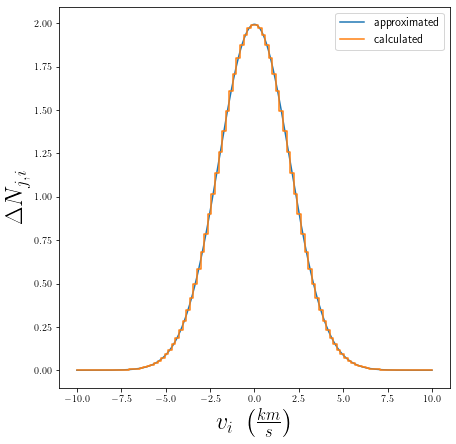

In [ ]:
v_i = np.linspace(-10, 10, num=100)

plot_clump_number(v_i=v_i, suggested_fix=suggested_fix)

Integrated intensity (no discretisation): 56.577767564965676
Integrated intensity (with discretisation): 56.57774622485996


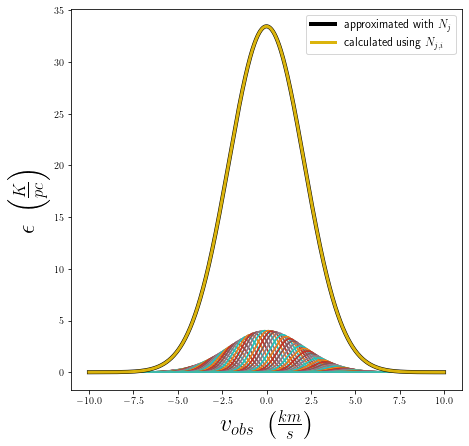

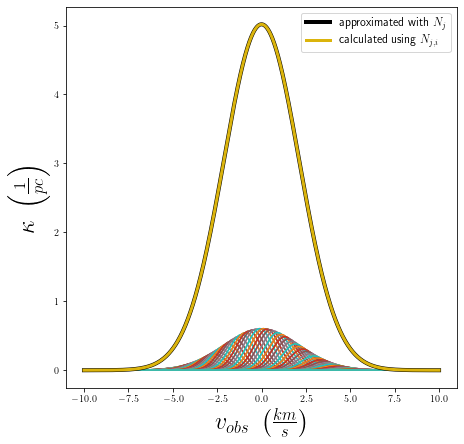

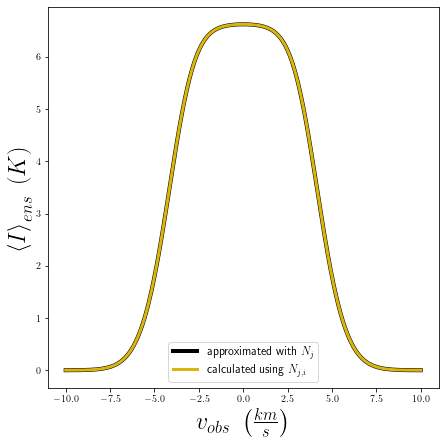

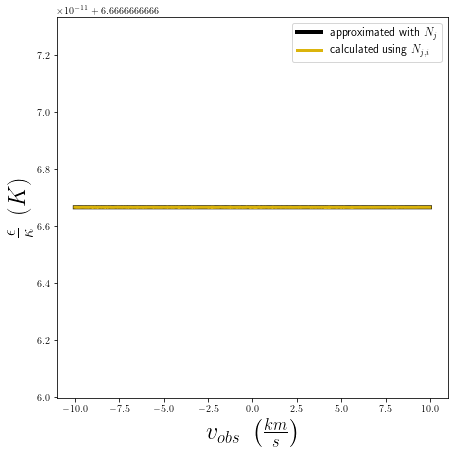

In [ ]:
plot_clumpy_emission(v_i=v_i, n_v=n_v, suggested_fix=suggested_fix);

Judging by the calculated $\varpi \equiv \int I dv$, this method performs with the same accuracy.

We also see that these approximations of the ensemble intensity both follow the same Gaussian distribution, since the factor of $\frac{\epsilon_{ens}}{\kappa_{ens}}$ is constant.

## Probabilistic approach

Thus-far we have merely considered how the discretisation affects the intensity of the ensemble. The full implementation of `kosmatau3d` uses a probabilistic approach to calculate the likelihood of having a given combination $k_{j,i}$ of clumps in your line-of-sight. The probability of each clump depends on its projected area ($\pi R_{cl}^2$) compared with the area of one face of the voxel ($\Delta s$).

$$
p_{j,i} = \binom{\Delta N_{j,i}}{k_{j,i}} \ p_j^{k_{j,i}} \ \left( 1 - p_j \right)^{\Delta N_{j,i} - k_{j,i}}
$$

This probability is then applied to the emissivity and opacity in different ways due to how they enter into the radiative transfer equation. For each systematic velocity,

$$
\begin{align}
\left< \epsilon \right>_{i} =& \sum_{k} \left( \prod_{j} p_{j,i} \right) \left( \sum_{j} k_{j,i} \epsilon_{j} \right) \ , \\
\left< \kappa \right>_{i} =& - \mathrm{log} \left[ \sum_{k} \left( \prod_{j} p_{j,i} \right) \mathrm{exp} \left( - \sum_{j} k_{j,i} \kappa_{j} \Delta s \right) \right] \ \div \ \Delta s \ .
\end{align}
$$

The voxel-averaged values are thus simply,

$$
\begin{align}
\left< \epsilon \right>_{vox} \left( v_{obs} \right) =& \sum_{i} \left< \epsilon \right>_{i} \left( v_{obs} \right) \ , \\
\left< \kappa \right>_{vox} \left( v_{obs} \right) =& \sum_{i} \left< \kappa \right>_{i} \left( v_{obs} \right) \ .
\end{align}
$$

In this manner the emissivity and opacity are decoupled and independant. There is an issue, though, since the sum over $v_i$ should occur before the probability of each combination is applied. Also, the probability should act on the intensity rather than the emissivity using $I_{\nu, i} = \frac{\epsilon_{\nu, i}}{\kappa_{\nu, i}} \bigg( 1 - exp \Big(- \kappa_{\nu, i} \Delta s \Big) \bigg)$. For these reasons the calculation should be corrected.

To avoid too many unnecessary loops, the suggestion is to calculate the clump number independant of $v_{i}$.

 > Assuming $\delta v_i << \sigma_{ens}$, then,
 >
 > $$
   \begin{align}
   \frac{dN_{j,i}}{dv_i} =& \ {\lim_{\delta v_i \to 0}} \left( \frac{\Delta N_{j,i}}{\delta v_i} \right) \ , \\
   =& \ \frac{N_j}{\sqrt{2 \pi \sigma_{ens}^2}} exp \Big( - \frac{(v_i-v_{vox})^2}{2 \sigma_{ens}^2} \Big) \ , \\
   =& \ \mathrm{constant}.
   \end{align}
   $$
 > 
 > Then for each observing velocity the sum over the contribution from each clump will be,
 > 
 > $$
   \begin{align}
   N_{j,i} =& \sum_i exp \Big( - \frac{(v_i-v_{obs})^2}{2\sigma_{cl}^2} \Big) \ \Delta N_{j,i} \ , \\
   =& \int_{-\inf}^\inf dv_i exp \Big( - \frac{(v_i-v_{obs})^2}{2\sigma_{cl}^2} \Big) \ \frac{dN_{j,i}}{dv_i} \ , \\
   =& \sqrt{2 \pi \sigma_{cl}^2} \ \frac{dN_{j,i}}{dv_i} \ , \\
   =& N_j \frac{\sigma_{cl}}{\sigma_{ens}} exp \Big( - \frac{(v_i-v_{vox})^2}{2 \sigma_{ens}^2} \Big) \ .
   \end{align}
   $$
 >
 > Since we are now including the contribution from clumps at other velocities in the definition of $N_{j,i}$, the velocity distribution of the ensemble is actually the total velocity dispersion $\sigma_{ens,eff}$. Below we examine the applicability of this assumption.

  Calculated curve area: 1.7797060749879714
Approximated curve area: 1.7797060749880098
      Formal curve area: 1.7797060749880105


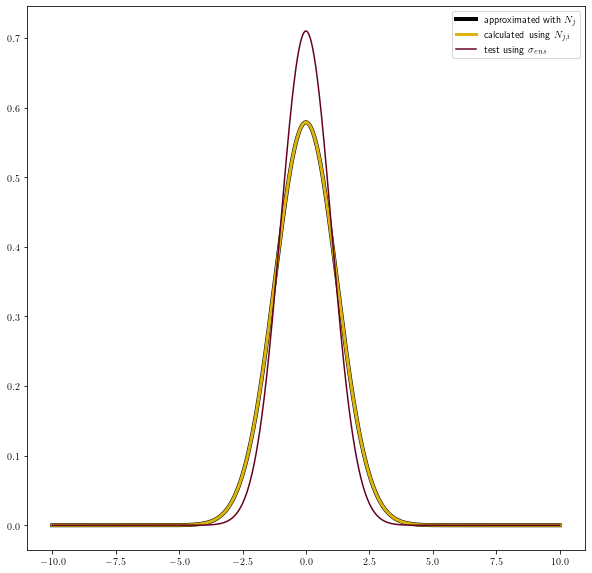

In [ ]:
# Isolate the scope of this cell
def test_dist():
    
    # Define dispersion variables unique to this cell
    sigma_cl_test = copy(sigma_cl)
    sigma_ens_test = 1
    sigma_ens_eff_test = np.sqrt(sigma_ens_test**2 + sigma_cl**2)

    # Velocity arrays
    v_obs = np.linspace(-10, 10, num=1000)
    v_i = np.linspace(-10, 10, num=2001).reshape(-1, 1)
    dv_i = v_i[1]-v_i[0]

    # Calculate N_j,i using various approximations 
    y1 = (1/np.sqrt(2*np.pi*sigma_ens_test**2) * np.exp(-(v_i-0)**2/2/sigma_ens_test**2) * np.exp(-(v_i-v_obs.reshape(1, -1))**2/2/sigma_cl_test**2)).sum(0) * dv_i
    y2 = (np.sqrt(2*np.pi*sigma_cl_test**2)/np.sqrt(2*np.pi*sigma_ens_eff_test**2) * np.exp(-(0-v_obs)**2/2/sigma_ens_eff_test**2))
    mu_test = (sigma_ens_test**2*v_obs/(sigma_ens_test**2-sigma_cl_test**2)).reshape(1, -1)
    sigma_test = (sigma_ens_test**2*sigma_cl_test**2)/(sigma_ens_test**2+sigma_cl_test**2)
    # y3 = (1/np.sqrt(2*np.pi*sigma_test**2) * np.exp(-(v_i-mu_test)**2/(2*sigma_test**2))).sum(0) * dv_i
    y3 = (np.sqrt(2*np.pi*sigma_cl_test**2)/np.sqrt(2*np.pi*sigma_ens_test**2) * np.exp(-(v_obs-0)**2/(2*sigma_ens_test**2)))

    # Plot the approximations
    plt.figure(figsize=(10, 10))
    plt.plot(v_obs, y2, **approximated_kwargs)
    plt.plot(v_obs, y1, **calculated_kwargs)
    plt.plot(v_obs, y3, color="xkcd:maroon", label=r"test using $\sigma_{ens}$")
    plt.legend()
    
    # Print the area under each curve
    print("  Calculated curve area:", np.trapz(y1, v_obs))
    print("Approximated curve area:", np.trapz(y2, v_obs))
    print("      Formal curve area:", np.trapz(y3, v_obs))
    
    return

test_dist()

As seen above, the use of $\sigma_{ens_{eff}}$ fits better than $\sigma_{ens}$, though the area under each curve is the same.

In [ ]:
md(r'Now we wish to apply this procedure to our previous example. Let us assume our clump has a radius of $R_{cl} =$'
   + r'{} $pc$.'.format(r_j))

Now we wish to apply this procedure to our previous example. Let us assume our clump has a radius of $R_{cl} =$[0.5] $pc$.

### With a coarse discretisation

First we examine how the original discretisation handles a dense voxel.

sigma: 2.0000


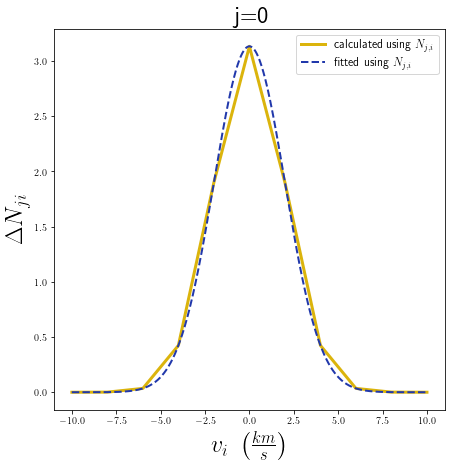

In [ ]:
v_i = np.linspace(-10, 10, num=11)

plot_probabilistic_dNji(v_i=v_i)

average sigma=2.0318, fully-fitted sigma=2.0318
       Integrated intensity (with discretisation): 41.6455063389164


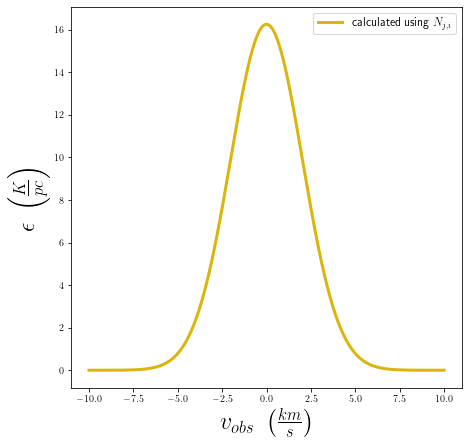

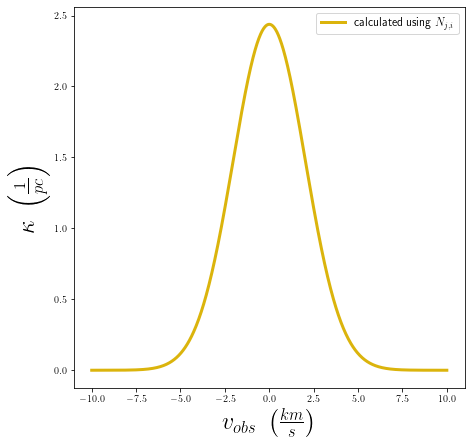

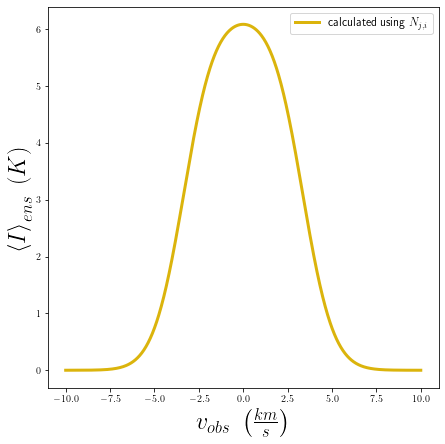

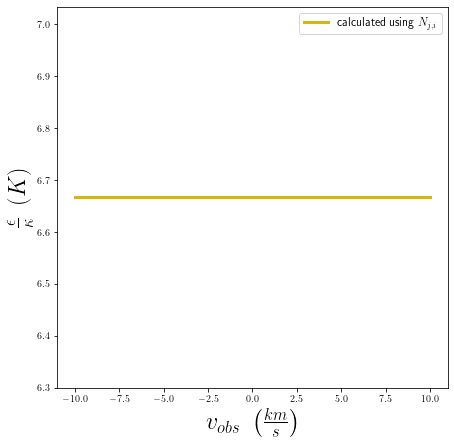

In [ ]:
# n_j = [10]
# nmax = 0
v_i = np.linspace(-10, 10, num=11)

plot_probabilistic_emission(v_i=v_i, n_v=None, suggested_fix=True, kind='gaussian', poisson=False, plotfit=False, linearfit=False, residual=False) ;

As it can be seen, there are some discontinuous features in the wings. So far as I can tell from the overall development of `kosmatau3d`, this is due to the probabilistic approach; each discontinuity is located where the there is a difference in the number of combinations considered. The initial fraction in the radiative transfer equation, $S = \left( \frac{\epsilon}{\kappa} \right)$, should cancel out any underlying structure and equate to a constant.

Now in the probabilistic discretisation, $\left< \epsilon \right>_{ens}$ and $\left< \kappa \right>_{ens}$ are not perfect Gaussians but follow a similar structure. For that reason we are mainly concerned with the smoothness of this initial fraction. When it has non-constant features, the resulting intensity $\left< I \right>_{vox} \left( v_{obs} \right)$ will also have these non-constant features.

Plots of this fraction can be seen in the final plot.

### Using a finer discretisation

Using a higher velocity resolution in the model should highlight some features that result from a numerical artefact.

sigma: 2.0000


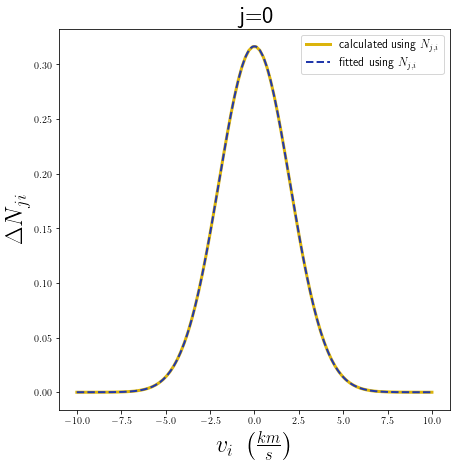

In [ ]:
v_i = np.linspace(-10, 10, num=100)

plot_probabilistic_dNji(v_i=v_i)

sigma: 2.0000


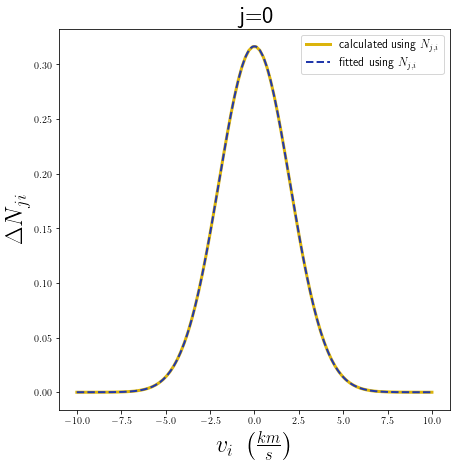

In [ ]:
v_i = np.linspace(-10, 10, num=100)

plot_probabilistic_dNji(v_i=v_i)

       Integrated intensity (with discretisation): 38.8776403382556


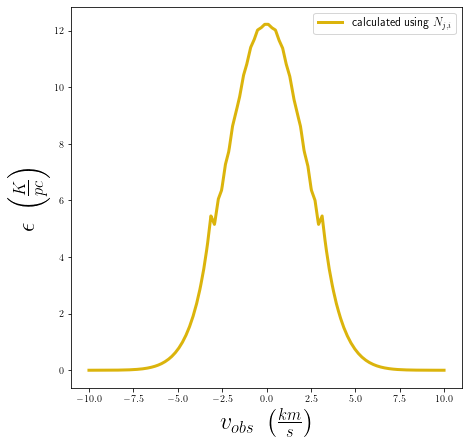

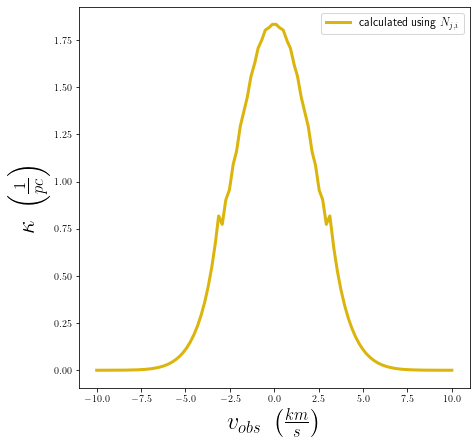

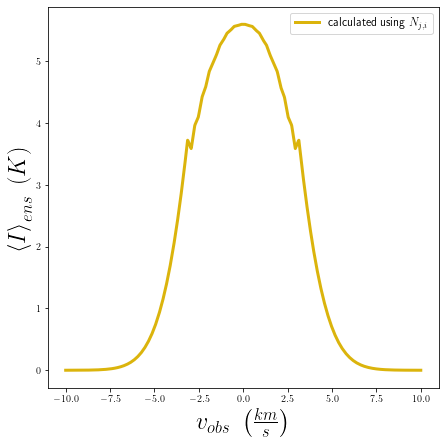

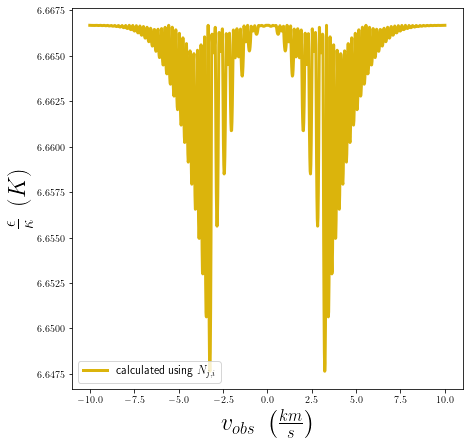

In [ ]:
n_j = [10]
nmax = 1
v_i = np.linspace(-10, 10, num=100)

plot_probabilistic_emission(v_i=v_i, n_v=None, nmax=nmax, suggested_fix=True, kind='slinear', poisson=False, plotfit=True, linearfit=False, residual=False, zoom=0) ;

There are still wavy features when `suggested_fix` is False, which is seen also in the source function.

It seems the wavy features are no longer an issue when using `suggested_fix`. However, the factor of $\frac{\left< \epsilon_\nu \right>_{vox}}{\left< \kappa_\nu \right>_{vox}}$ used to judge the validity of the discrete clump calculation will not work for the raw calculation due to the use of $\left< \tau_\nu \right>_{vox}$ in deriving $\left< \epsilon_\nu \right>_{vox}$. Despite this, we can be sure of its validity of this calculation due to the theoretical derivation and limiting of initial assumptions. Specifying the *gaussian* method of interpolation will in fact fit a Gaussian to the emissivity and optical depth, so the souce function will in fact be flat.

## Fitting

When not using the suggested calculation, the previous plots not only show that a smooth fraction will result in a smooth absorption feature, but also that $\left< \epsilon \right>_{ens}$ and $\left< \kappa \right>_{ens}$ follow different distributions. To approximate this in terms of a Gaussian, we will perform a fit to examine how much they differ.

In [ ]:
def eps_eff(v, a, sigma_eff):
    return np.sum([a * n_ens[cl]*eps_j[cl]/np.sqrt(2*np.pi*sigma_eff**2) * np.exp(-v**2/2/sigma_eff**2) for cl in range(len(n_ens))], axis=0)

def kap_eff(v, a, sigma_eff):
    return np.sum([a * n_ens[cl]*kap_j[cl]/np.sqrt(2*np.pi*sigma_eff**2) * np.exp(-v**2/2/sigma_eff**2) for cl in range(len(n_ens))], axis=0)

In [ ]:
# Only fit the emissivity and opacity when using the former calculation of the intensity
if not suggested_fix:
    
    def fit_emission():
    
        a_eps, sigma_eps_eff = curve_fit(eps_eff, v_obs, eps_ens, [1, sigma_ens])[0]
        a_kap, sigma_kap_eff = curve_fit(kap_eff, v_obs, kap_ens, [1, sigma_ens])[0]

        print('fitted amplitudes:\n{}\n{}\n'.format(a_eps, a_kap))
        print('fitted dispersions:\n{}\n{}\n'.format(sigma_eps_eff, sigma_kap_eff))

        eps_fit = eps_eff(v_obs, a_eps, sigma_eps_eff)
        kap_fit = kap_eff(v_obs, a_kap, sigma_kap_eff)

        # Emissivity
        plt.figure(figsize=figsize)
        plt.plot(v_obs, eps, c='xkcd:black', lw=3, label='approximated')
        plt.plot(v_obs, eps_fit, c='xkcd:charcoal', lw=2, ls='-', label='fitted')
        plt.plot(v_obs, eps_ens, c='xkcd:vomit', lw=2, ls='--', label='calculated')
        plt.legend(fontsize=fontsize*legend_factor)
        plt.title('Fitted emissivity', fontsize=fontsize)
        plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        plt.ylabel(r'$\left< \epsilon \right>_{ens} \ \left( \frac{K}{pc} \right)$', fontsize=fontsize)
        
        # Opacity
        plt.figure(figsize=figsize)
        plt.plot(v_obs, kap, c='xkcd:black', lw=3, label='approximated')
        plt.plot(v_obs, kap_fit, c='xkcd:charcoal', lw=2, ls='-', label='fitted')
        plt.plot(v_obs, kap_ens, c='xkcd:vomit', lw=2, ls='--', label='calculated')
        plt.legend(fontsize=fontsize*legend_factor)
        plt.title('Fitted opacity', fontsize=fontsize)
        plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        plt.ylabel(r'$\left< \kappa \right>_{ens} \ \left( \frac{1}{pc} \right)$', fontsize=fontsize)
        
        # Ratio
        plt.figure(figsize=figsize)
        plt.plot(v_obs, eps/kap, c='xkcd:black', lw=3, label='approximated')
        plt.plot(v_obs, eps_fit/kap_fit, 
                 c='xkcd:charcoal', lw=2, ls='-', label='fitted')
        plt.plot(v_obs, eps_ens/kap_ens, c='xkcd:vomit', lw=2, ls='--', label='calculated')
        plt.legend(fontsize=fontsize*legend_factor)
        plt.title('Fitted fraction', fontsize=fontsize)
        plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        plt.ylabel(r'$\frac{\left< \epsilon \right>_{ens}}{\left< \kappa \right>_{ens}} \ \left( K \right)$', fontsize=fontsize)
        
        # Intensity
        plt.figure(figsize=figsize)
        plt.plot(v_obs, eps/kap*(1-np.exp(-kap*ds)), c='xkcd:black', lw=3, label='approximated')
        plt.plot(v_obs, eps_fit/kap_fit*(1-np.exp(-kap_fit*ds)), c='xkcd:charcoal', lw=2, ls='-', label='fitted')
        plt.plot(v_obs, eps_ens/kap_ens*(1-np.exp(-kap_ens*ds)), c='xkcd:vomit', lw=2, ls='--', label='calculated')
        plt.legend(fontsize=fontsize*legend_factor)
        plt.title('Fitted Intensity', fontsize=fontsize)
        plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        plt.ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize)
        
        return
    
    fit_emission()

NameError: name 'v_obs' is not defined

## Final remarks

When using the original calculations, it is clear that the probabilistic approach affects the behaviour of the emissivity and opacity with respect to observing velocity. Using a standard assumption that both the emissivity and the absorption follow the same Gaussian distribution with velocity dispersion $\sigma_{ens, eff}$, their ratio will cause the Gaussian distributions to cancel and the result will be a value constant with respect to observing velocity. If we assume the emissivity and opacity follow two slightly different Gaussians (as in the fitted values), then the ratio will also have a Gaussian structure. What seems to be happening in the probabilistic approach is that the voxel-averaged emissivity follows a more strongly-peaked Gaussian than the voxel-averaged opacity near the center velocity, whereas they follow the same Gaussian distribution far away from the center velocity. The pseudo-Gaussian behaviour of these values appear to cause the steep edges in the wings of the intensity plot. The fitted emissivity and opacity are very close to the voxel-averaged values, but they are unable to capture these sharp wings.

Another implementation suggestion is to remove the internal velocity grid entirely and use a modified $\sigma_{ens}$ in the exponent (as demonstrated when `suggested_fix`=True) when calculating the number of clumps. It is sufficiently shown above that this effectively increases the number of clumps at each observing velocity and it works suitably-well for approximating the intensity of the voxel. While this does not suffer from the self-absorbtion numerical error of the original calculation and is much more computationally-efficient, it still has some intrinsic error from its implementation. There is a discontinuity introduced when the number of combinations increases due the probability. It can be shown above (by setting `kind`='gaussian' and `plotfit`=True) that the emissivity and optical depth curves are still mostly Gaussian, so this numerical artefact should not introduce a large error. Still, it is possible to fit a Gaussian function to remove this artefact. Another benefit of the newer calculation is that it does not require a dense internal velocity grid.